### Starbucks in Seattle

Can we determine the furthest you can get from a starbucks is at any given time? Opendata has a complete (?) list of all starbucks stores that we can filter by any of the columns, along with their longitude and latitude coordinates.


In [223]:
import numpy as np
import pandas as pd
import datetime
import urllib
import math

params = {'country':'us',
          'city'   :'Seattle'}

query = ("https://opendata.socrata.com/resource/xy4y-c4mk.json?country={country}&city={city}".format(**params))

store_data = pd.read_json(query)

We check the cells, and ask how many starbucks stores are in Seattle

In [224]:
store_data.head()

,brand,city,coordinates,country,country_subdivision,current_timezone_offset,first_seen,latitude,longitude,name,...,ownership_type,phone_number,postal_code,store_id,store_number,street_1,street_2,street_3,street_combined,timezone
0,Starbucks,Seattle,"{u'latitude': u'47.6214942932129', u'needs_rec...",US,WA,-480,2013-12-08T22:41:59,47.621494,-122.338158,Westlake & Thomas - Seattle,...,CO,{u'phone_number': u'206-382-4624'},981095218,6432,13915-105892,330 Westlake Ave N,NaN,NaN,330 Westlake Ave N,Pacific Standard Time
1,Starbucks,Seattle,"{u'latitude': u'47.5222320556641', u'needs_rec...",US,WA,-480,2013-12-08T22:41:59,47.522232,-122.365662,QFC - West Wood Village #825,...,LS,{u'phone_number': u'206-935-0585'},98126,7113,79328-101213,2500 SW Barton,NaN,NaN,2500 SW Barton,Pacific Standard Time
2,Starbucks,Seattle,"{u'latitude': u'47.4455146789551', u'needs_rec...",US,WA,-480,2013-12-08T22:41:59,47.445515,-122.303696,"SEA SeaTac Concourse C, C12",...,LS,{u'phone_number': u'206-433-5131'},981581132,7209,72303-94442,2580 S 156th St,NaN,Seattle-Tacoma International Airport,"2580 S 156th St, Seattle-Tacoma International ...",Pacific Standard Time
3,Starbucks,Seattle,"{u'latitude': u'47.6070594787598', u'needs_rec...",US,WA,-480,2013-12-08T22:41:59,47.607059,-122.309250,James Tower,...,LS,{u'phone_number': u'206-325-6750'},981225788,7327,75364-102761,550 17th Ave,NaN,NaN,550 17th Ave,Pacific Standard Time
4,Starbucks,Seattle,"{u'latitude': u'47.6101531982422', u'needs_rec...",US,WA,-480,2013-12-08T22:41:59,47.610153,-122.333076,Two Union Square,...,CO,{u'phone_number': u'206-264-2534'},981012341,7328,114-101752,601 Union Street,224B,NaN,"601 Union Street, 224B",Pacific Standard Time


In [225]:
print "There are", store_data.shape[0], "stores in this dataset"

There are 156 stores in this dataset


# Which store is the closest to a given point?

We can divide Seattle up into [Voronoi cells](https://en.wikipedia.org/wiki/Voronoi_diagram) generated with the location of Starbucks stores. The idea is

* Every polygon or cell will have exactly one store in it
* The cell consists of all points for which that starbucks store is the closest
* The points furthest from any starbucks store will be the vertices between the cells.

For example, if there were only two stores, then the Voronoi diagram would be the line that divided the two cells. We can use scipy's implementation of Voronoi.

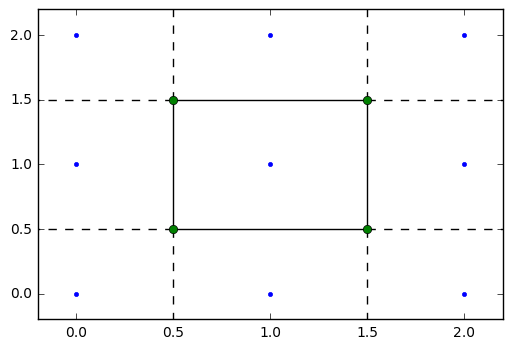

In [226]:
# We are only importing matplotlib as an example to show what a Voronoi cell is
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

# Here is an example of 9 points laid out on a 3x3 grid, with the Voronoi cells.
points = np.array([ [x,y] for x in range(3) for y in range(3)])
vor = Voronoi(points)
voronoi_plot_2d(vor)
plt.show()

### How to get infomation out of Voronoi

From the 9 original points, `vor` separates the  plane into 9 regions (technically, 10, but one region is empty). The lines separating the regions intersect at 4 points, which are stored as vertices in `vor`.  It is important to note that vertices refer to the intersections of the lines, and **not** the original points.

Any line segment making up the cells is either between two of the vertices, or goes from one vertex to infinity. The regions are stored  as a list of vertex indices, or -1 if the line goes to infinity, to describe the length of the path. For example, we have
  vor.vertices = [ [0.5,0.5], [1.5,0.5], [0.5,1.5], [1.5,1.5] ]

* The central  region is then can be represented as [0,2,3,1], or any cyclic permutation.
* The upper left region can be represented as [2,-1], or [-1,2]
* The upper middle region can be represented as [2,3,-1]

It is important to understand this encoding, as we have to manually make the Voronoi cells on the map as there is not currently a helper function like `veronoi_plot_2d` for folium or bokeh maps. We could use `matplotlib` and `basemap` instead, but we would give up being able to interact with the map. 

In [227]:
# A check on the output of vor
print vor.vertices
print vor.regions, len(vor.regions)

# Note we can get a point for each region. Region assumes points is a 1-based array, 
# and that is why vor.regions[0] = []
print vor.points, vor.point_region

print 
for index, point in enumerate(vor.points):
    print "Point {} is in region {} (i.e. the region {})".format(point, vor.point_region[index], 
                                                                 vor.regions[vor.point_region[index]])

[[ 0.5  0.5]
 [ 1.5  0.5]
 [ 0.5  1.5]
 [ 1.5  1.5]]
[[], [-1, 0], [-1, 1], [1, -1, 0], [3, -1, 2], [-1, 3], [-1, 2], [3, 2, 0, 1], [2, -1, 0], [3, -1, 1]] 10
[[ 0.  0.]
 [ 0.  1.]
 [ 0.  2.]
 [ 1.  0.]
 [ 1.  1.]
 [ 1.  2.]
 [ 2.  0.]
 [ 2.  1.]
 [ 2.  2.]] [1 8 6 3 7 4 2 9 5]

Point [ 0.  0.] is in region 1 (i.e. the region [-1, 0])
Point [ 0.  1.] is in region 8 (i.e. the region [2, -1, 0])
Point [ 0.  2.] is in region 6 (i.e. the region [-1, 2])
Point [ 1.  0.] is in region 3 (i.e. the region [1, -1, 0])
Point [ 1.  1.] is in region 7 (i.e. the region [3, 2, 0, 1])
Point [ 1.  2.] is in region 4 (i.e. the region [3, -1, 2])
Point [ 2.  0.] is in region 2 (i.e. the region [-1, 1])
Point [ 2.  1.] is in region 9 (i.e. the region [3, -1, 1])
Point [ 2.  2.] is in region 5 (i.e. the region [-1, 3])


## Building the map

Building a map with Folium is straightforward, and gives a nice Javascript enabled map that we can interact with, even on a static site like GitHub Pages.  The newest version, 0.3.0, has just come out and some of the documentation for altering maps is still being developed. There is a lot of documentation and examples for 0.2.0, but unfortunately a lot of changes are not backward compatible. 

In [228]:
# Building our map
import folium
import json

# Making a map with folium is straightforward:
seattle_map = folium.Map(location = [store_data['latitude'].mean(), store_data['longitude'].mean()], 
                         zoom_start = 13, tiles='Stamen Terrain',
                         min_lat = store_data['latitude'].min(), max_lat = store_data['latitude'].max(),
                         min_lon = store_data['longitude'].min(),max_lon = store_data['longitude'].max()
                        )

# show the map
seattle_map

In [229]:
# make the voronoi cells for the starbucks stores.
# This is hard to do on a sphere, so we make the simplifying assumption that 1 degree latitude is the same regardless
# of where you are on the map (i.e. we are assuming the map is small). 
# Note that 
# 1 degree latitude = (1/360) circumfrence of Earth = (1/360) x (2 pi R)
# 1 degree longitude= (1/360) circumfrence of circle with this latitude
#                   = (1/360)(2 pi R cos(theta)), theta = latitude
#                   = (1 degree latitude distance ) * cos(theta)
# so we still need to correct for 1 degree lat != 1 degree long (except at equator)
scale_long = math.cos( math.radians(store_data['latitude'].mean()) )
store_data['longitude_distance'] = store_data['longitude'] * scale_long

vorBucks = Voronoi(zip(store_data['longitude_distance'], store_data['latitude']))

# now correct the scaling in the verticies
vorBucks.vertices = [ [v[0]/scale_long, v[1]] for v in vorBucks.vertices ]
vorBucks.points   = [ [v[0]/scale_long, v[1]] for v in vorBucks.points   ]

## Adding Voronoi cells

Now we are going to add the Voronoi cells on top of this. This requires manually putting together a GeoJSON object (!). 

The process is somewhat cumbersome. We need to make a list of all the regions in vorBucks.regions that are not empty (so exclude []) and not infinite (so exclude any that include the vertex -1). 

For each region, we then have to construct a polygon in GeoJSON format. For a cell with N points, this is a dictionary of the form

`{type: "Polygon", 
  coordinates: [[ [long1,lat1], [long2,lat2], ..., [longN, latN], [long1,lat1] ]]
  }`
  
It is  important to ensure the Polygon is closed (so first and last points are the same). 

Finally, all the Voronoi cells are put together in a "FeatureCollection" GeoJSON object:

`{type: "FeatureCollection", 
  features: [ GeoJSON_For_cell1, Geo_JSON_For_cell2, ....]
  }`

In [230]:
def makeGeoPolygon(vertices, region):
    """vertices is a list of (x,y) pairs indicating the coordiantes of the vertex.
    
       region is a list of vertex indices."""
    if -1 in region or region == []:
        return None    
    poly = [[vertices[v][0], vertices[v][1]] for v in region]
    poly = poly + [poly[0]]
    return {"type": "Polygon", "coordinates": [poly] }

vorGeoJSON = {
    "type": "FeatureCollection",
    "features": [ {"type": "Feature", 
                   "geometry": makeGeoPolygon(vorBucks.vertices, region)} 
                 for region in vorBucks.regions if (-1 not in region) and (len(region) > 0)
                ]
}


# Now add regions from vorGeoJSON onto map
seattle_map.choropleth(geo_str=json.dumps(vorGeoJSON),fill_color='#00704A',
                       fill_opacity = 0.0,line_weight=0.8,
                       line_color="#008800",highlight=True,
                       legend_name = "store regions")

# Show the map with the cells.
# (We will add the stores next)
seattle_map

In [231]:
# now customize map by adding starbucks stores to it. We will also add detailed tooltips for when you click on a store.
# (If we add stores before we add the cells, the cells lie "on top" of the stores, and we don't have the ability to click on the store to 
# get the tooltip)
my_popup_html="""
<!DOCTYPE html>
<html><head>
<style>
  table {{ width: 100%;}}
  
  table, th, td {{
    border: 1px solid black;
    border-collapse: collapse;
  }}

  th, td {{
    padding: 5px;
    text-align: left;
}}
table#t01 tr:nth-child(odd) {{
    background-color: #8e8;
}}
table#t01 tr:nth-child(even) {{
   background-color:#fff;
}}
</style>
</head>
<body>
  <table id="t01">
    <tr> <td>Name</td> <td>{name}</td> </tr>
    <tr> <td>Store type</td> <td>{ownership_type}</td> </tr>
    <tr> <td>Address</td> <td>{street_1}</td></tr>
  </table>
  
</body>
</html>
""".format

for _, row in store_data.iterrows():
    tableFrame = folium.IFrame(html=my_popup_html(**row), width = 500, height=300)
    popupTable = folium.Popup(tableFrame,max_width=500)
    
    folium.CircleMarker(
        location = [row["latitude"], row["longitude"]],  # Note that NS comes before EW for folium!
        radius   = 5,
        fill_color = "#00704A",                          # the starbucks green!
        popup = popupTable
    ).add_to(seattle_map)

# Print the new map
seattle_map

## Finding the point furthest from a starbucks

We know that the point furthest from a starbucks is going to be one of the vertices in the Voronoi data structure. We probably are not interested in points in Lake Washington, or in the Puget sound, and some of our vertices are a long way away because we artificially restricted the starbucks we were using to "Seattle". As we get to outer regions, we cannot really rely on the cells anymore, because there might be a starbucks **just** outside the region we are querying.

For that reason, the approach I will take is to  only look at points inside a bounding box.

In [232]:
# Use the quartiles for flexibility
longMin = store_data['longitude'].describe()['25%']
longMax = store_data['longitude'].describe()['75%']
latMin  = store_data['latitude'].describe()['25%']
latMax  = store_data['latitude'].describe()['75%']

# Find all vertices in vorBux that are within the bounding box
vertInBB = filter(lambda v: (v[1][0] < longMax)*(longMin < v[1][0])*(v[1][1]<latMax)*(latMin < v[1][1]), 
                  enumerate(vorBucks.vertices))

# For each vertex in the BB, find out which regions it is on the boundary of. Then search for the store coords in those
# regions. Finally, find the distance between the store and the point

# First do a scan so we can look up the point associated with each region
vorBucks.region_point = [-1]*len(vorBucks.regions)

for index,point in enumerate(vorBucks.points):
    vorBucks.region_point[ vorBucks.point_region[index] ] = index

distanceArray = []
for index, vertex in vertInBB:
    theRegions  = [regionNum for regionNum, region in enumerate(vorBucks.regions) if index in region]
    try:
        storesCoord = [vorBucks.points[vorBucks.region_point[r]] for r in theRegions]
    
        # should be equidistant from all points
        displacement =  np.array(storesCoord[0]) - np.array(vertex)
        distance2     = (scale_long*displacement[0])**2 + displacement[1]**2
        distanceArray.append( (distance2, index, vertex) )
    except:
        pass

# Make sure the furthest minimum distance to a starbucks appears first by sorting in
# descending order
distanceArray.sort(reverse = True)

# Useful conversion to convert 1 degree latitude into meters
REarth       = 6.367e6
distInMeters = math.sqrt(distanceArray[0][0])*2*math.pi*REarth / 360.0

print """
The furthest you can be from a starbucks is at {loc}.
You would be {dist:4.2f} meters ({distMi:4.2f} in miles) from the nearest starbucks.
""".format(loc = distanceArray[0][2], dist = distInMeters, distMi = distInMeters/1600.0)

# Add this marker onto the map in red
folium.CircleMarker(location = [distanceArray[0][2][1], distanceArray[0][2][0]],
                    radius = 5, color = "#FF0000",
                    popup  = "Furthest point in BB from a starbucks").add_to(seattle_map)

seattle_map


The furthest you can be from a starbucks is at [-122.33387356837885, 47.650514448027728].
You would be 1220.51 meters (0.76 in miles) from the nearest starbucks.



## Where is the bounding box? How do we sanity check?

The bounding box doesn't acutally appear on our map. We will add it (using another GeoJSON object), as well as giving the option to turn it off by adding a Layer control. This will give our final map.

In [233]:
BBGeoJSON = {
    'type':'Polygon',
    'coordinates':[[
        [longMin,latMin], [longMax,latMin],[longMax,latMax],[longMin,latMax],[longMin,latMin]        
    ]]
}

### It turns out that seattle_map.choropleth is probably going to be depreciated, see this post
### http://nbviewer.jupyter.org/github/python-visualization/folium/blob/master/examples/GeoJSON_and_choropleth.ipynb?flush_cache=true
###
### Commented code below works (except it has a bad "layer name" that we cannot change), added non-depreciated method
#seattle_map.choropleth(geo_str=json.dumps(BBGeoJSON),fill_color='#DDDDDD',
#                       fill_opacity = 0.0,line_weight=2.1,
#                       line_color="#FF8800",highlight=True,
#                       legend_name = "bounding box")

folium.GeoJson(
    BBGeoJSON,
    name='Bounding Box',
    style_function=lambda _: {
        'fillColor': '#DDDDDD',
        'color': '#FF8800',
        'weight': 2.1,
        'fillOpacity': 0.15,
    }
).add_to(seattle_map)

folium.LayerControl().add_to(seattle_map)

In [234]:
seattle_map

### Final note

I added the layers in the following way:

1. First we made the map
2. Then we added the Voronoi cells
3. Then we added the stores
4. Then we added the bounding box

I did this for motivational reasons. We should really swap the order of steps 2 and 4, because the bounding box is "blocking" the Voronoi cells and the stores that are inside the box (i.e. the region of interest).

Thankfully, we can recycle a lot of our layers on a new map.

In [235]:
# Create a new map
seattle_map2 = folium.Map(location = [store_data['latitude'].mean(), store_data['longitude'].mean()], 
                         zoom_start = 13, tiles='Stamen Terrain',
                         min_lat = store_data['latitude'].min(), max_lat = store_data['latitude'].max(),
                         min_lon = store_data['longitude'].min(),max_lon = store_data['longitude'].max()
                        )

# put down the bounding box
folium.GeoJson(
    BBGeoJSON,
    name='Bounding Box',
    style_function=lambda _: {
        'fillColor': '#DDDDDD',
        'color': '#FF8800',
        'weight': 2.1,
        'fillOpacity': 0.15,
    }
).add_to(seattle_map2)

# put down the Voronoi cells
seattle_map2.choropleth(geo_str=json.dumps(vorGeoJSON),fill_color='#00704A',
                       fill_opacity = 0.0,line_weight=0.8,
                       line_color="#008800",highlight=True,
                       legend_name = "store regions")

# put down the store markers
for _, row in store_data.iterrows():
    tableFrame = folium.IFrame(html=my_popup_html(**row), width = 500, height=300)
    popupTable = folium.Popup(tableFrame,max_width=500)
    
    folium.CircleMarker(
        location = [row["latitude"], row["longitude"]],  # Note that NS comes before EW for folium!
        radius   = 5,
        fill_color = "#00704A",                          # the starbucks green!
        popup = popupTable
    ).add_to(seattle_map2)
    
# put down the furthest distance point
folium.CircleMarker(location = [distanceArray[0][2][1], distanceArray[0][2][0]],
                    radius = 5, color = "#FF0000",
                    popup  = "Furthest point in BB from a starbucks").add_to(seattle_map2)

# add the Layer Control
folium.LayerControl().add_to(seattle_map2)

# Now show the final map
seattle_map2

# Conclusion and next steps

By looking at the bounding box we used, it **could** be argued that the bounding box we used was too small. At least it gives us some confidence in the final result. Looking at the map, it seemed obvious that the starbucks out in Queen Anne, for example, was more isolated than the starbucks we ultimately chose.

Using the interquartile longitudes and latitudes has nicely isolated the downtown area, rather than the residential area.

Note this appoach is flexible enough that we could run the same code on another city by changing the query at the top of the document.

Next steps might be:
    
* Make a heat map, which allows us to look at the number of starbucks in different areas, without getting overwhelmed.
* I had tried to look at where the more recent stores were being added, but most of these stores were added to the dataset in 2013. There is not good data on when the stores were made, so it doesn't make sense to look for trends.
* Look at property prices near and far from Starbucks. Zillow [did a similar analysis](https://www.zillow.com/research/starbucks-home-value-appreciation-8912/?-0315_prdigest-0304starbucksheader) and claimed that Starbucks moving in meant property prices were going to lead. Can we confirm this analysis?
    
One way of viewing this project is just as a way of getting familiar with the Folium mapping project. I need to either find (or develop) tools to make the task of constructing GeoJSON objects less tedious and error-prone!